In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-11-12 12:17:50.851390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 12:17:51.071793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 12:17:51.197030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 12:17:51.224381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 12:17:51.371101: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Define paths to metadata files and image directories
train_metadata_path = '/home/raymondvoong/aml/datasetass2/PV train.csv'
test_seen_metadata_path = '/home/raymondvoong/aml/datasetass2/PV test seen.csv'
test_unseen_metadata_path = '/home/raymondvoong/aml/datasetass2/PV test unseen.csv'
pd_test_unseen_metadata_path = '/home/raymondvoong/aml/datasetass2/PD test unseen.csv'


In [3]:
plantvillage_dir = '/home/raymondvoong/aml/datasetass2/plantvillage'
plantdoc_dir = '/home/raymondvoong/aml/datasetass2/plantdoc'

In [4]:
# Define image dimensions
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3  # RGB images
BATCH_SIZE = 32

In [5]:
# Load the metadata for training and testing
train_metadata = pd.read_csv(train_metadata_path)
test_seen_metadata = pd.read_csv(test_seen_metadata_path)
test_unseen_metadata = pd.read_csv(test_unseen_metadata_path)
pd_test_unseen_metadata = pd.read_csv(pd_test_unseen_metadata_path)

In [6]:
# Rename columns to make them consistent
train_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']
test_seen_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']
test_unseen_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']
pd_test_unseen_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']


In [7]:
# Use only the crop category as the label for classification
train_metadata['label'] = train_metadata['crop_category'].astype(str)
test_seen_metadata['label'] = test_seen_metadata['crop_category'].astype(str)
test_unseen_metadata['label'] = test_unseen_metadata['crop_category'].astype(str)
pd_test_unseen_metadata['label'] = pd_test_unseen_metadata['crop_category'].astype(str)

In [8]:
# Data Augmentation for Training Data
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# Testing Data Generator (only rescale, no augmentation)
test_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

In [10]:
# Function to generate data from a DataFrame
def dataframe_generator(df, base_dir, target_size, batch_size, data_gen, class_mode, label_column):
    return data_gen.flow_from_dataframe(
        dataframe=df,
        directory=base_dir,
        x_col='image_file_name',
        y_col=label_column,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True
    )

In [11]:
# Generate training and testing data
train_data = dataframe_generator(train_metadata, plantvillage_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, train_data_gen, 'categorical', 'label')
pv_test_seen_data = dataframe_generator(test_seen_metadata, plantvillage_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, test_data_gen, 'categorical', 'label')
pv_test_unseen_data = dataframe_generator(test_unseen_metadata, plantvillage_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, test_data_gen, 'categorical', 'label')
pd_test_unseen_data = dataframe_generator(pd_test_unseen_metadata, plantdoc_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, test_data_gen, 'categorical', 'label')

Found 38993 validated image filenames belonging to 14 classes.
Found 10278 validated image filenames belonging to 14 classes.
Found 215 validated image filenames belonging to 1 classes.
Found 70 validated image filenames belonging to 1 classes.


In [12]:
# Define the number of classes
num_classes = len(train_data.class_indices)

In [13]:
# Section 4: Model Construction and Compilation (Updated)

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the CNN model architecture
def build_cnn_model(input_shape=(299, 299, 3), num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
# Initialize and compile the model
cnn_model = build_cnn_model(input_shape=(299, 299, 3), num_classes=num_classes)
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

I0000 00:00:1731385080.140593   12679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731385080.904341   12679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731385080.904470   12679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731385080.922648   12679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731385080.922742   12679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [15]:
# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [16]:
# Train the model
history = cnn_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    epochs=15,
    validation_data=pv_test_seen_data,
    validation_steps=pv_test_seen_data.samples // BATCH_SIZE,
    callbacks=[reduce_lr, early_stop]
)

/home/raymondvoong/aml/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1731385095.407536   12797 service.cc:146] XLA service 0x7f6b70016480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731385095.408042   12797 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-11-12 12:18:15.489509: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 12:18:15.884596: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   2/1218 ━━━━━━━━━━━━━━━━━━━━ 1:02 51ms/step - accuracy: 0.0859 - loss: 3.8514  

I0000 00:00:1731385103.482380   12797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 420s 336ms/step - accuracy: 0.4936 - loss: 1.6731 - val_accuracy: 0.7821 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 2/15
   1/1218 ━━━━━━━━━━━━━━━━━━━━ 3:38 179ms/step - accuracy: 0.6875 - loss: 0.9511

2024-11-12 12:25:11.987674: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-12 12:25:11.987717: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-12 12:25:11.987729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:25:11.987745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.6875 - loss: 0.9511 - val_accuracy: 0.6667 - val_loss: 0.7641 - learning_rate: 0.0010
Epoch 3/15


2024-11-12 12:25:13.264558: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-12 12:25:13.264604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:25:13.264620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 415s 341ms/step - accuracy: 0.7107 - loss: 0.8811 - val_accuracy: 0.8385 - val_loss: 0.4960 - learning_rate: 0.0010
Epoch 4/15
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.7812 - loss: 0.6280 - val_accuracy: 0.6667 - val_loss: 1.4222 - learning_rate: 0.0010
Epoch 5/15


2024-11-12 12:32:08.366807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:32:08.366862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
2024-11-12 12:32:08.536001: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-12 12:32:08.536049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:32:08.536068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 402s 330ms/step - accuracy: 0.7696 - loss: 0.7144 - val_accuracy: 0.8833 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 6/15
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 1.0000 - loss: 0.2557 - val_accuracy: 0.8333 - val_loss: 0.6378 - learning_rate: 0.0010


2024-11-12 12:38:50.296593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:38:50.296660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
2024-11-12 12:38:50.483397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:38:50.483444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


Epoch 7/15
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 398s 327ms/step - accuracy: 0.8065 - loss: 0.5996 - val_accuracy: 0.9075 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 8/15
   1/1218 ━━━━━━━━━━━━━━━━━━━━ 4:20 214ms/step - accuracy: 0.9062 - loss: 0.4190

2024-11-12 12:45:28.674537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:45:28.674601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
2024-11-12 12:45:28.882728: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-12 12:45:28.882765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:45:28.882783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9062 - loss: 0.4190 - val_accuracy: 0.8333 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 9/15
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 402s 330ms/step - accuracy: 0.8343 - loss: 0.5086 - val_accuracy: 0.9213 - val_loss: 0.2456 - learning_rate: 0.0010
Epoch 10/15
   1/1218 ━━━━━━━━━━━━━━━━━━━━ 1:21 67ms/step - accuracy: 0.9062 - loss: 0.2787
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.9062 - loss: 0.2787 - val_accuracy: 0.8333 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 11/15


2024-11-12 12:52:12.053159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:52:12.053216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
2024-11-12 12:52:12.117093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:52:12.117146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 397s 326ms/step - accuracy: 0.8772 - loss: 0.3747 - val_accuracy: 0.9392 - val_loss: 0.2047 - learning_rate: 5.0000e-04
Epoch 12/15
   1/1218 ━━━━━━━━━━━━━━━━━━━━ 3:52 191ms/step - accuracy: 0.9062 - loss: 0.3229

2024-11-12 12:58:48.953779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:58:48.954432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
2024-11-12 12:58:49.139472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 12:58:49.139521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.9062 - loss: 0.3229 - val_accuracy: 1.0000 - val_loss: 0.1217 - learning_rate: 5.0000e-04
Epoch 13/15
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 397s 326ms/step - accuracy: 0.8893 - loss: 0.3368 - val_accuracy: 0.9427 - val_loss: 0.1906 - learning_rate: 5.0000e-04
Epoch 14/15
   1/1218 ━━━━━━━━━━━━━━━━━━━━ 1:19 65ms/step - accuracy: 0.7812 - loss: 0.6626

2024-11-12 13:05:26.601678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 13:05:26.601731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122
2024-11-12 13:05:26.663728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1780953327168491790
2024-11-12 13:05:26.663787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18212596753205999122


1218/1218 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7812 - loss: 0.6626 - val_accuracy: 1.0000 - val_loss: 0.0356 - learning_rate: 5.0000e-04
Epoch 15/15
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 396s 325ms/step - accuracy: 0.8934 - loss: 0.3289 - val_accuracy: 0.9426 - val_loss: 0.1809 - learning_rate: 5.0000e-04


In [17]:
# Evaluate on PV Unseen Test Set
pv_test_unseen_data.reset()
pv_unseen_loss, pv_unseen_accuracy = cnn_model.evaluate(pv_test_unseen_data)
print(f"PlantVillage Unseen Test Set Accuracy: {pv_unseen_accuracy:.4f}")

/home/raymondvoong/aml/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.2945 - loss: 124.9409
PlantVillage Unseen Test Set Accuracy: 0.2884


In [18]:
# Evaluation
print("Evaluating on PV Seen Test Set:")
pv_seen_loss, pv_seen_accuracy = cnn_model.evaluate(pv_test_seen_data)
print(f"PlantVillage Seen Test Set Accuracy: {pv_seen_accuracy:.4f}")

Evaluating on PV Seen Test Set:
322/322 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9366 - loss: 0.2102
PlantVillage Seen Test Set Accuracy: 0.9405


In [19]:
# Evaluate on PD Unseen Test Set
pd_test_unseen_data.reset()
pd_unseen_loss, pd_unseen_accuracy = cnn_model.evaluate(pd_test_unseen_data)
print(f"PlantDoc Unseen Test Set Accuracy: {pd_unseen_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 0.0110 - loss: 192.3495
PlantDoc Unseen Test Set Accuracy: 0.0143


In [20]:
# Harmonic Mean Calculation
harmonic_mean_accuracy = 2 * (pv_seen_accuracy * pv_unseen_accuracy) / (pv_seen_accuracy + pv_unseen_accuracy)
print(f"Harmonic Mean Accuracy between Seen and Unseen: {harmonic_mean_accuracy:.4f}")

Harmonic Mean Accuracy between Seen and Unseen: 0.4414


In [21]:
# Top-N accuracy calculation function
def top_n_accuracy(predictions, true_labels, n=5):
    top_n_preds = np.argsort(predictions, axis=1)[:, -n:]
    return np.mean([true_labels[i] in top_n_preds[i] for i in range(len(true_labels))])

In [22]:
# Predict and evaluate Top-1 and Top-5 accuracies
pv_test_unseen_data.reset()
predictions = cnn_model.predict(pv_test_unseen_data, steps=pv_test_unseen_data.samples // BATCH_SIZE + 1)
predicted_classes = predictions.argmax(axis=1)
true_classes = pv_test_unseen_data.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [23]:
top_1_accuracy = top_n_accuracy(predictions, true_classes, n=1)
top_5_accuracy = top_n_accuracy(predictions, true_classes, n=5)
print(f"Top-1 Accuracy: {top_1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

Top-1 Accuracy: 0.2884
Top-5 Accuracy: 0.8930


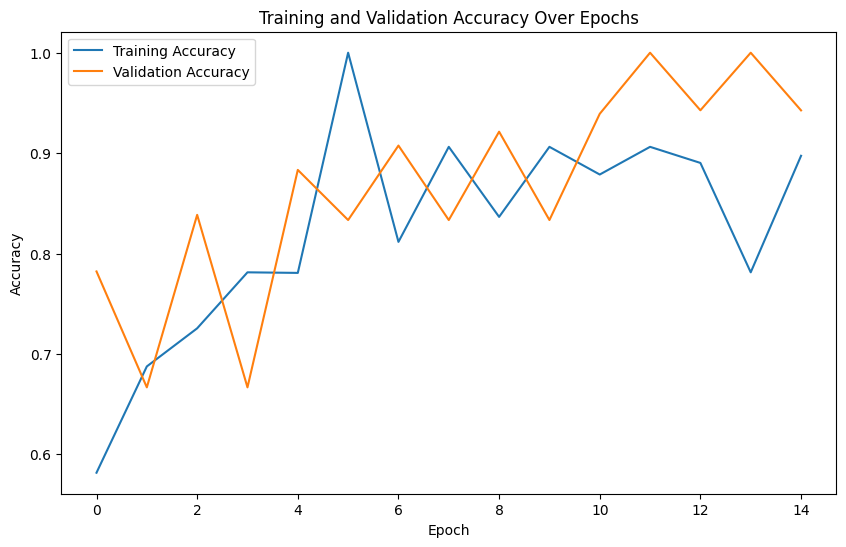

In [24]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()